In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

## For this project I'm using 2019 player information from fifa. I got this csv from kaggle, but the same dataset can be found on the thinkful postgres sql server

In [2]:
# import data
fifa19 = pd.read_csv('/Users/richardlafferty/Downloads/fifa19.csv')

In [3]:
# checking data info
fifa19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [4]:
display(fifa19.head())

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## I am going to be looking to run a regression algorithm which will let me find with reasonable accuracy, the value of a player in regards to his salary. My goal is to see if I can optimize a fantasy draft.

In [5]:
fifa19.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [6]:
# I think some of these are inconsequential to us and I'll drop them now
fifa19 = fifa19.drop(['Photo', 'Flag', 'Club Logo', 'ID',
                      'Jersey Number', 'Real Face', 
                      'Contract Valid Until', 'Joined'], axis=1)

In [7]:
#list of numeric columns
cont_columns = list(fifa19.select_dtypes(exclude='object'))
#list of categorical columns
cat_columns = list(fifa19.select_dtypes('object'))
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
['Name', 'Nationality', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Release Clause']


In [8]:
fifa19.head()

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [9]:
fifa19.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause'],
   

In [10]:
#looking at null values
print((fifa19.isnull().sum().sort_values(ascending=False)))

Loaned From        16943
RWB                 2085
LM                  2085
CB                  2085
LCB                 2085
LB                  2085
RDM                 2085
CDM                 2085
LDM                 2085
LWB                 2085
RM                  2085
RCM                 2085
CM                  2085
LCM                 2085
RAM                 2085
RB                  2085
CAM                 2085
LAM                 2085
RW                  2085
RF                  2085
CF                  2085
LF                  2085
LW                  2085
RS                  2085
ST                  2085
LS                  2085
RCB                 2085
Release Clause      1564
Club                 241
Position              60
                   ...  
Interceptions         48
SprintSpeed           48
Volleys               48
ShortPassing          48
HeadingAccuracy       48
Finishing             48
Crossing              48
Aggression            48
LongPassing           48


In [11]:
#dropping loaned from because it's missing over 90% of its data
fifa19 = fifa19.drop(['Loaned From'], axis=1)

In [12]:
fifa19.loc[fifa19.CDM.isnull()]
#so there are some pretty important players missing these values. 
#I would hate to lose that data. I'll have to interpolate the nulls

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,€58M,€240K,1328,...,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,€123.3M
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,€53.5M,€240K,1311,...,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,€38M,€130K,1473,...,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,€62.7M
37,37,H. Lloris,31,France,88,88,Tottenham Hotspur,€36M,€150K,1335,...,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0,€66.6M
40,40,S. Handanovič,33,Slovenia,88,88,Inter,€30M,€110K,1262,...,69.0,25.0,10.0,13.0,87.0,86.0,69.0,89.0,89.0,€51M
41,41,G. Buffon,40,Italy,88,88,Paris Saint-Germain,€4M,€77K,1334,...,70.0,13.0,11.0,11.0,88.0,87.0,74.0,90.0,83.0,€7.4M
46,46,K. Navas,31,Costa Rica,87,87,Real Madrid,€30.5M,€195K,1345,...,67.0,28.0,14.0,14.0,90.0,81.0,75.0,82.0,90.0,€62.5M
57,57,Ederson,24,Brazil,86,90,Manchester City,€41.5M,€125K,1463,...,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0,€79.9M


In [13]:
'''#I will fill these null values using interpolation
fifa19 = fifa19.interpolate()'''

'#I will fill these null values using interpolation\nfifa19 = fifa19.interpolate()'

In [14]:
fifa19.CDM.value_counts()

62+2    660
60+2    620
61+2    620
64+2    592
59+2    592
63+2    573
58+2    565
65+2    539
57+2    529
66+2    524
56+2    520
54+2    505
55+2    479
53+2    471
51+2    468
49+2    448
52+2    444
50+2    438
68+2    428
48+2    427
67+2    426
47+2    396
69+2    362
46+2    359
44+2    339
45+2    325
70+2    302
43+2    282
71+2    271
42+2    239
       ... 
82+3      8
62+3      7
69+3      6
52+3      6
66+3      6
57+3      6
53+3      6
63+3      6
79+3      5
51+3      5
81+2      5
65+3      4
29+2      4
54+3      4
64+3      4
67+3      4
68+3      3
45+3      2
50+3      2
84+3      2
49+3      2
83+2      1
82+2      1
86+3      1
68+5      1
28+2      1
46+3      1
57+4      1
85+3      1
87+3      1
Name: CDM, Length: 99, dtype: int64

In [15]:
#all these columns have a + value added, 
#which according to my soccer friends is not important 
cols = ["LS", "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM", "LCM",
        "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB", "CB", "RCB", "RB"]
for col in cols:
    fifa19[col] = fifa19[col].str[:-2]
    fifa19[col] = fifa19[col].astype(float)

In [16]:
print(fifa19['Height'].head())
print(fifa19['Height'].isnull().sum())
fifa19['Height'].dropna(inplace=True)

0     5'7
1     6'2
2     5'9
3     6'4
4    5'11
Name: Height, dtype: object
48


In [17]:
#write a function that splits height into feet and inches and returns just inches as a float
def parse_height(ht):
    height = ht.split("'")
    #print(height) #used this to see my output after splitting
    feet = float(height[0])
    inches = float(height[1])
    return (12*feet) + inches
fifa19['Height'] = fifa19['Height'].apply(lambda x: parse_height(x))


In [18]:
#Correct Weight
fifa19['Weight']=fifa19['Weight'].str[:-3]
fifa19['Weight']=fifa19['Weight'].astype(float)

print(fifa19.Height.head())
print(fifa19.Weight.head())


0    67.0
1    74.0
2    69.0
3    76.0
4    71.0
Name: Height, dtype: float64
0    159.0
1    183.0
2    150.0
3    168.0
4    154.0
Name: Weight, dtype: float64


In [19]:
#changing all currency columns into float columns to help analyze

curs=["Release Clause", "Value", "Wage"]
for cur in curs:
    
    def curr_value(x):
        x = str(x).replace('€', '')
        if('M' in str(x)):
            x = str(x).replace('M', '')
            x = float(x) * 1000000
        elif('K' in str(x)):
            x = str(x).replace('K', '')
            x = float(x) * 1000
        return float(x)
    fifa19[cur] = fifa19[cur].apply(curr_value)

In [20]:
cont_columns = cont_columns + curs
cat_columns = ['Name', 'Nationality', 'Club', 'Preferred Foot',
               'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight',
               'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
               'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB',
               'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
               'International Reputation', 'Weak Foot', 'Skill Moves']

In [21]:
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause', 'Value', 'Wage']
['Name', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'International Reputation', 'Weak Foot', 'Skill Moves']


In [22]:
#looking at our target variable
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
inf


In [23]:
#having an inf value will certainly mess up our model so I will try to take care of it now
fifa19.value_overall = fifa19.value_overall.replace(np.inf, np.nan)
print(fifa19.value_overall.max())
print(fifa19.value_overall.isnull().sum())
#if we only have 252 null values then I feel ok with just dropping those rows
print(fifa19.value_overall.head())



0.006
252
0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64


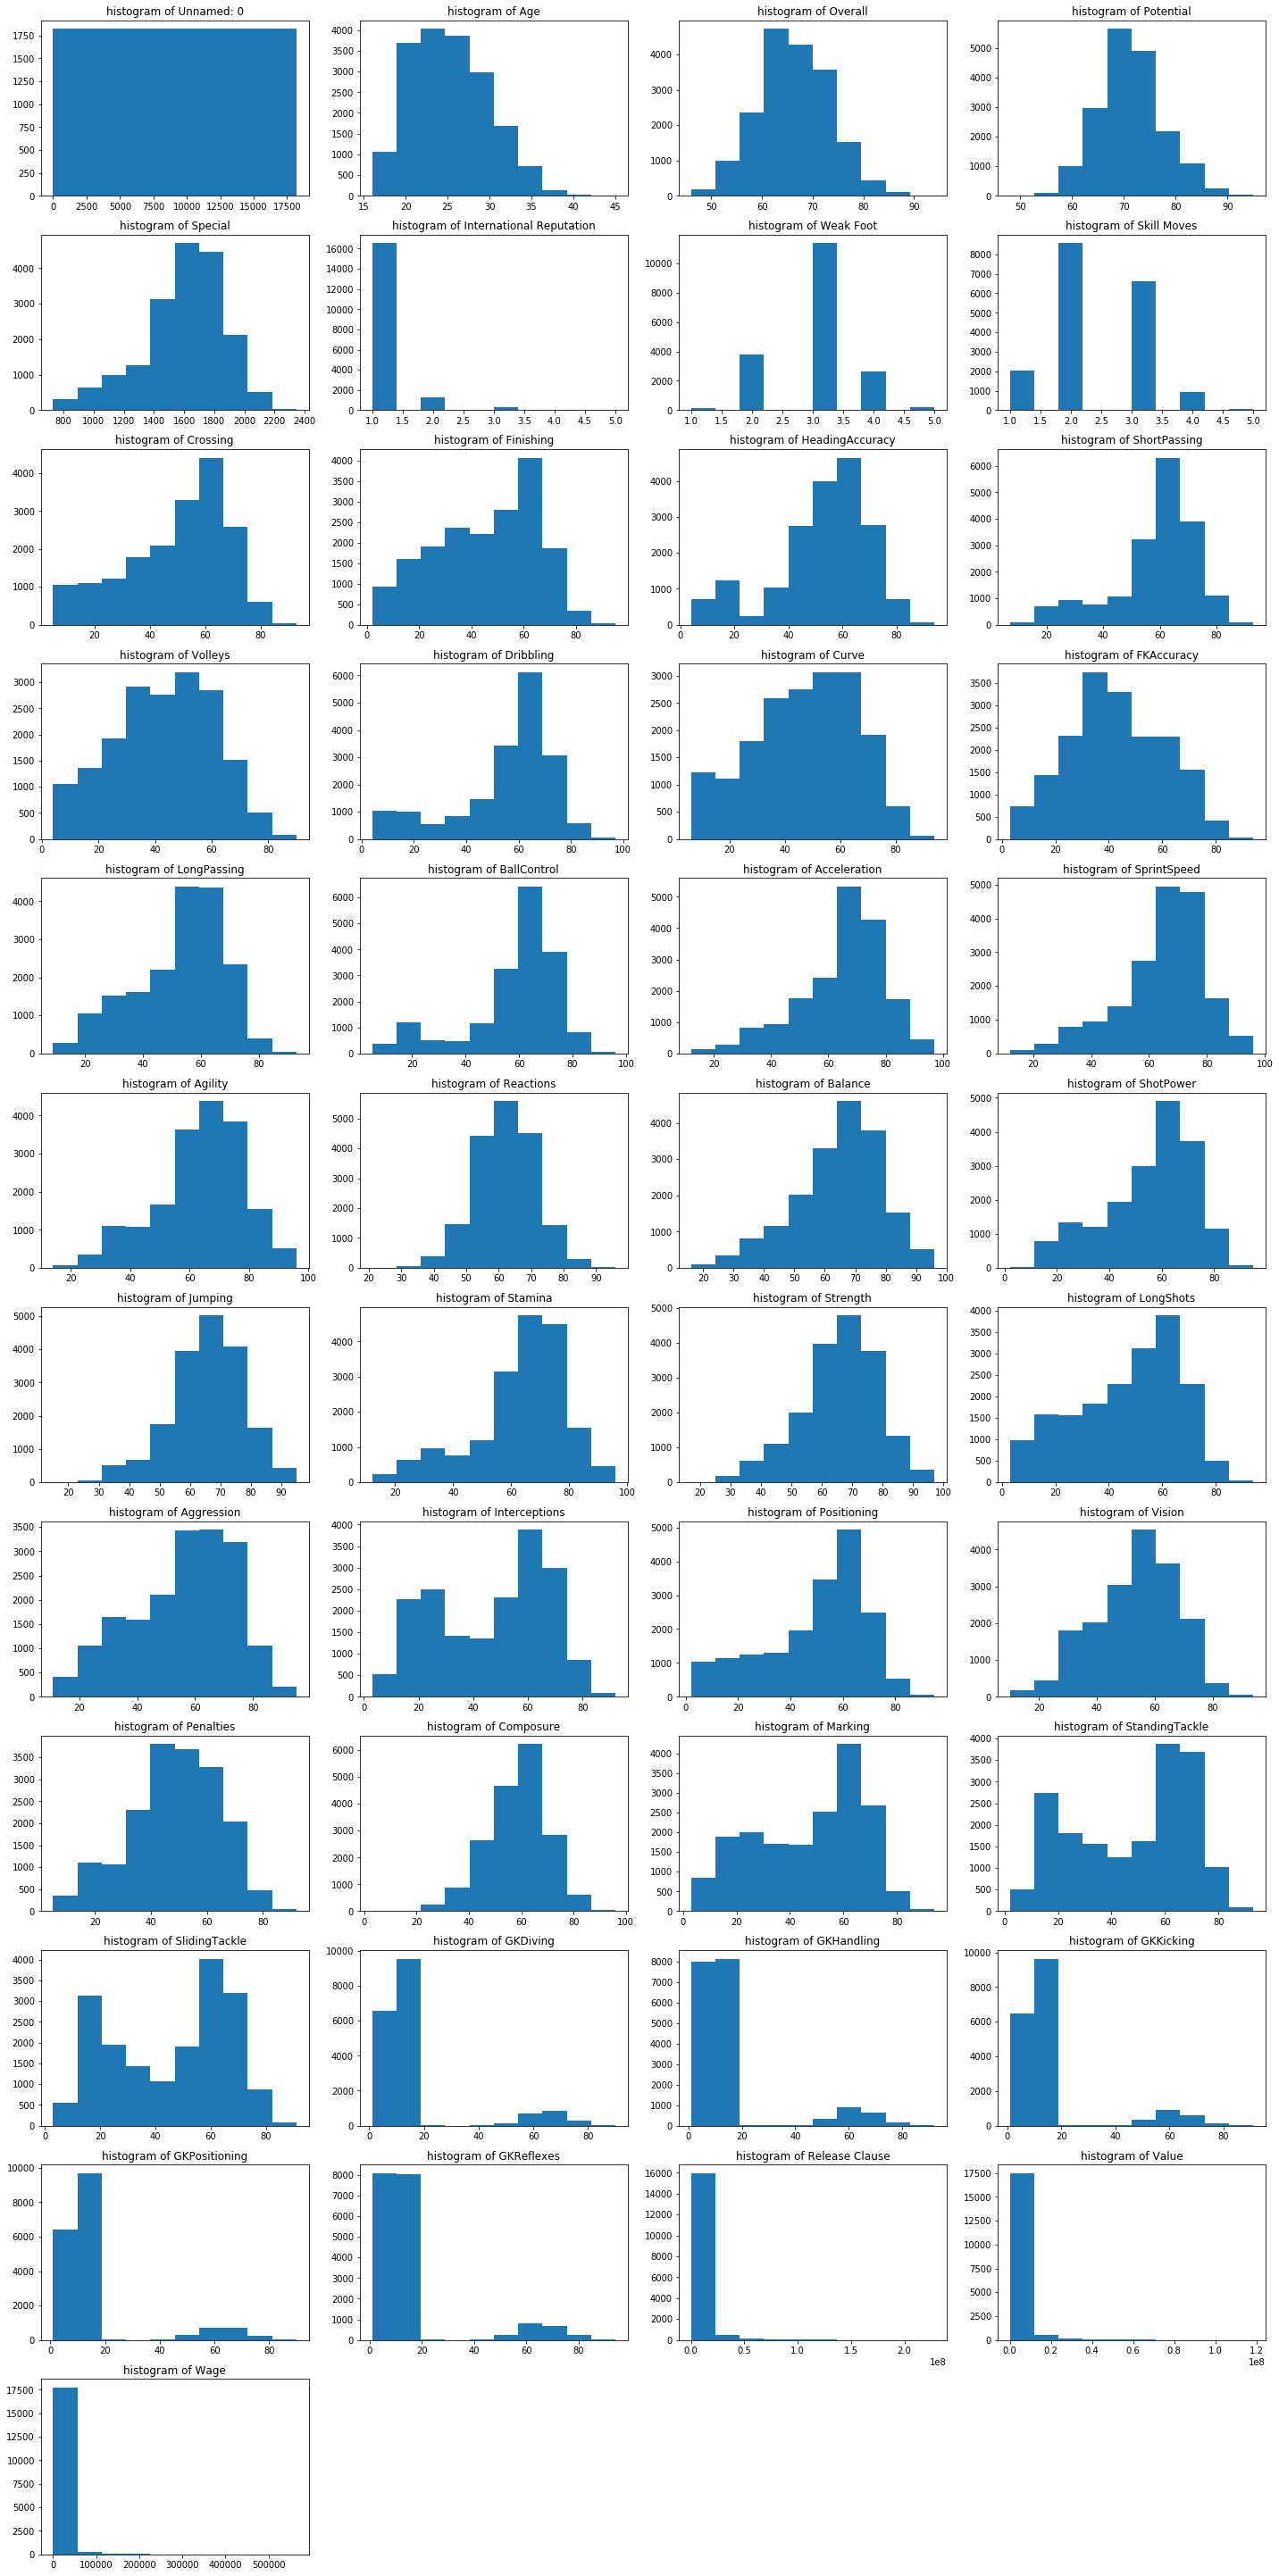

In [24]:
fig = plt.figure(figsize=(20,150))
for i, col in enumerate(cont_columns):
    
    plt.subplot(len(cont_columns), 4, i+1)
    plt.hist(fifa19[col])
    plt.title('histogram of {}'.format(col))
    plt.tight_layout()

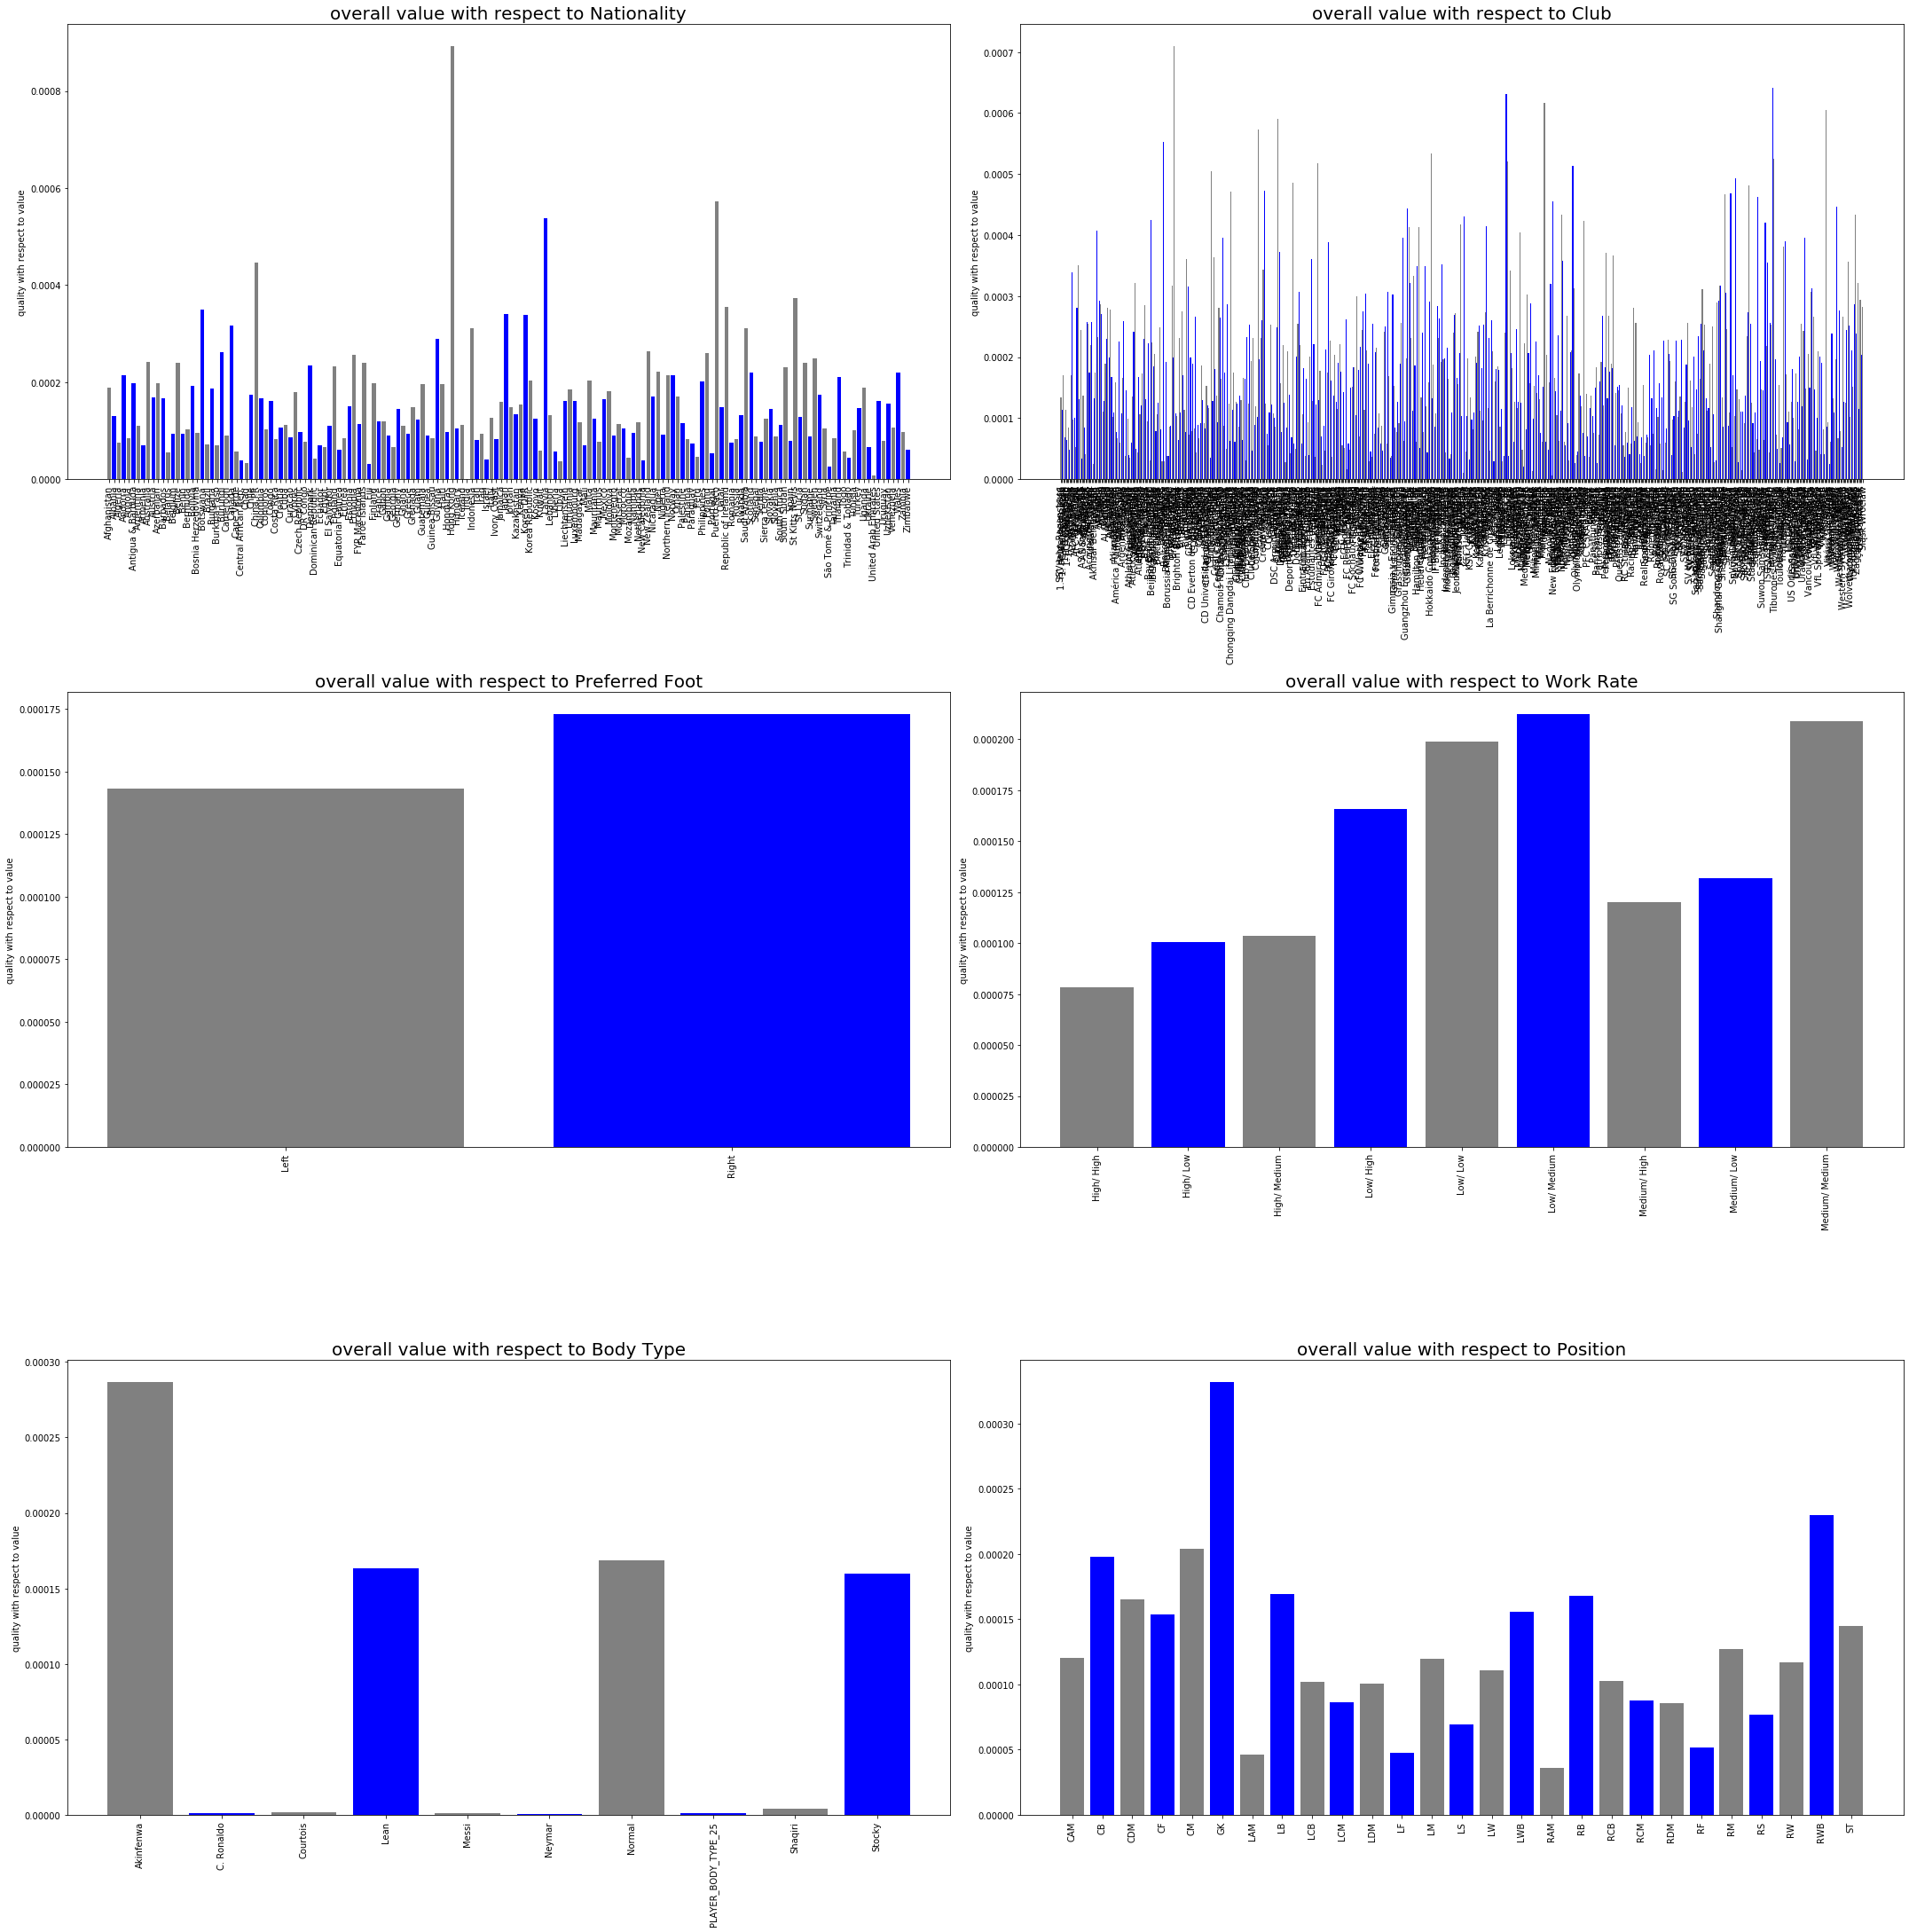

In [25]:
object_columns = ['Nationality',
                  'Club',
                  'Preferred Foot',
                  'Work Rate',
                  'Body Type',
                  'Position']

plt.figure(figsize=(30, 60))
for i, col in enumerate(object_columns):
    plt.subplot(len(object_columns), 2, i+1)
    plt.bar(fifa19.groupby(col)['value_overall'].mean(
    ).index, fifa19.groupby(col)['value_overall'].mean(), color=('grey', 'blue'))
    plt.ylabel('quality with respect to value')
    plt.xticks(rotation='vertical')
    plt.title('overall value with respect to {}'.format(col), fontsize=20)
    plt.tight_layout()
    #there's a lot of noise in the Nationality and Club

In [26]:
#I feel like there's too much noise in the nationality variable and Club variable

fifa19 = fifa19.drop(columns=['Nationality', 'Club'])


In [27]:
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
fifa19 = fifa19.replace([np.inf, -np.inf], np.nan)

print(fifa19.isnull().sum().sort_values(ascending=False))


LCB                2085
RB                 2085
CB                 2085
LB                 2085
RWB                2085
RDM                2085
CDM                2085
LDM                2085
LWB                2085
RM                 2085
RCM                2085
CM                 2085
LCM                2085
LM                 2085
RAM                2085
CAM                2085
LAM                2085
RW                 2085
RF                 2085
CF                 2085
LF                 2085
LW                 2085
RS                 2085
ST                 2085
LS                 2085
RCB                2085
Release Clause     1564
value_overall       252
Position             60
FKAccuracy           48
                   ... 
Vision               48
Composure            48
Interceptions        48
Acceleration         48
Dribbling            48
Volleys              48
ShortPassing         48
HeadingAccuracy      48
Finishing            48
Aggression           48
LongPassing     

In [28]:
#using interpolation to fill missing values
fifa19.interpolate(inplace=True)
fifa19.isnull().sum().sort_values(ascending=False)

Position           60
Body Type          48
Work Rate          48
Preferred Foot     48
value_overall       0
LM                  0
RF                  0
RW                  0
LAM                 0
CAM                 0
RAM                 0
LCM                 0
LF                  0
CM                  0
RCM                 0
RM                  0
LWB                 0
LDM                 0
CDM                 0
RDM                 0
CF                  0
ST                  0
LW                  0
Special             0
Name                0
Age                 0
Overall             0
Potential           0
Value               0
Wage                0
                   ..
Marking             0
Jumping             0
StandingTackle      0
SlidingTackle       0
GKDiving            0
GKHandling          0
GKKicking           0
GKPositioning       0
GKReflexes          0
Stamina             0
ShotPower           0
CB                  0
Dribbling           0
RCB                 0
RB        

In [29]:
#dropping the final few null rows. With over 18k observations still I feel ok
fifa19.dropna(inplace=True)
fifa19.isnull().sum()

Unnamed: 0                  0
Name                        0
Age                         0
Overall                     0
Potential                   0
Value                       0
Wage                        0
Special                     0
Preferred Foot              0
International Reputation    0
Weak Foot                   0
Skill Moves                 0
Work Rate                   0
Body Type                   0
Position                    0
Height                      0
Weight                      0
LS                          0
ST                          0
RS                          0
LW                          0
LF                          0
CF                          0
RF                          0
RW                          0
LAM                         0
CAM                         0
RAM                         0
LM                          0
LCM                         0
                           ..
Curve                       0
FKAccuracy                  0
LongPassin

## All null and inf values have been taken care of and now I can start dealing with outliers

In [30]:
print(len(fifa19))

18147


In [32]:
cont_columns = ['Unnamed: 0', 'Age', 'Overall',
                'Potential', 'Special', 'Crossing',
                'Finishing', 'HeadingAccuracy', 'ShortPassing',
                'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                'LongPassing', 'BallControl', 'Acceleration',
                'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                'ShotPower', 'Jumping', 'Stamina', 'Strength',
                'LongShots', 'Aggression', 'Interceptions',
                'Positioning', 'Vision', 'Penalties', 'Composure',
                'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
                'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
                'Release Clause', 'Value', 'Wage', 'LS', 'Weight', 'RCM', 'RWB']
#cont_columns = fifa19.select_dtypes(exclude='object')
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                              len((np.where((fifa19[col] > max_val) |
                                                                                            (fifa19[col] < min_val))[0])), len((np.where((fifa19[col] > max_val) |
                                                                                                                                         (fifa19[col] < min_val))[0]))*100/18147))

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
Number of outliers and percentage of it in Age : 47 and %0.25899597729652285
Number of outliers and percentage of it in Overall : 163 and %0.898220091475175
Number of outliers and percentage of it in Potential : 160 and %0.881688433349865
Number of outliers and percentage of it in Special : 546 and %3.0087617788064143
Number of outliers and percentage of it in Crossing : 0 and %0.0
Number of outliers and percentage of it in Finishing : 0 and %0.0
Number of outliers and percentage of it in HeadingAccuracy : 998 and %5.499531603019783
Number of outliers and percentage of it in ShortPassing : 1727 and %9.516724527470105
Number of outliers and percentage of it in Volleys : 0 and %0.0
Number of outliers and percentage of it in Dribbling : 1923 and %10.59679285832369
Number of outliers and percentage of it in Curve : 0 and %0.0
Number of outliers and percentage of it in FKAccuracy : 0 and %0.0
Number of outliers and percentag

In [33]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0])),len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0]))*100/18147))
    
    
    print('percent of outliers low')
    print(len(np.where(fifa19[col] < min_val)[0]) /18147)
    print('Percent of outliers high')
    print(len(np.where(fifa19[col] > max_val)[0]) /18147)
    print(90 * '-')

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Age : 47 and %0.25899597729652285
percent of outliers low
0.0
Percent of outliers high
0.0025899597729652285
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Overall : 163 and %0.898220091475175
percent of outliers low
0.002920592935471428
Percent of outliers high
0.006061607979280322
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Potential : 160 and %0.881688433349865
percent of outliers low
0.0015980602854466302
Percent of outliers high
0.007218824048052019
------------------------------------------------------------------------------------------
Number of outli

In [34]:
len(fifa19)

18147

## Winsorizing continuous variables

In [35]:
#for loop for winsorizing outlier values
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    fifa19[col] = winsorize(fifa19[col], (len(np.where(fifa19[col] < min_val)[0]) / 18147,
                                          len(np.where(fifa19[col] > max_val)[
                                              0]) / 18147
                                          )
                            )

In [36]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0])),len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0]))*100/18147))
    
    
    print('percent of outliers low')
    print(len(np.where(fifa19[col] < min_val)[0]) /18147)
    print('Percent of outliers high')
    print(len(np.where(fifa19[col] > max_val)[0]) /18147)
    print(90 * '-')

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Age : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Overall : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Potential : 29 and %0.15980602854466303
percent of outliers low
0.0015980602854466302
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Special : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high

0.0034165426792307266
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in RCM : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in RWB : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------


In [38]:
#a few outliers still sneaked in so I'll manually take care of that now
fifa19['Potential'] = winsorize(fifa19['Potential'], (.0016, 0))
fifa19['Acceleration'] = winsorize(fifa19['Acceleration'], (.0265, 0))
fifa19['ShotPower'] = winsorize(fifa19['ShotPower'], (.00083, 0))
fifa19['Weight'] = winsorize(fifa19['Weight'], (.0035, 0))

In [39]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
# get dummies for our X values
y = fifa19['value_overall']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
0.006


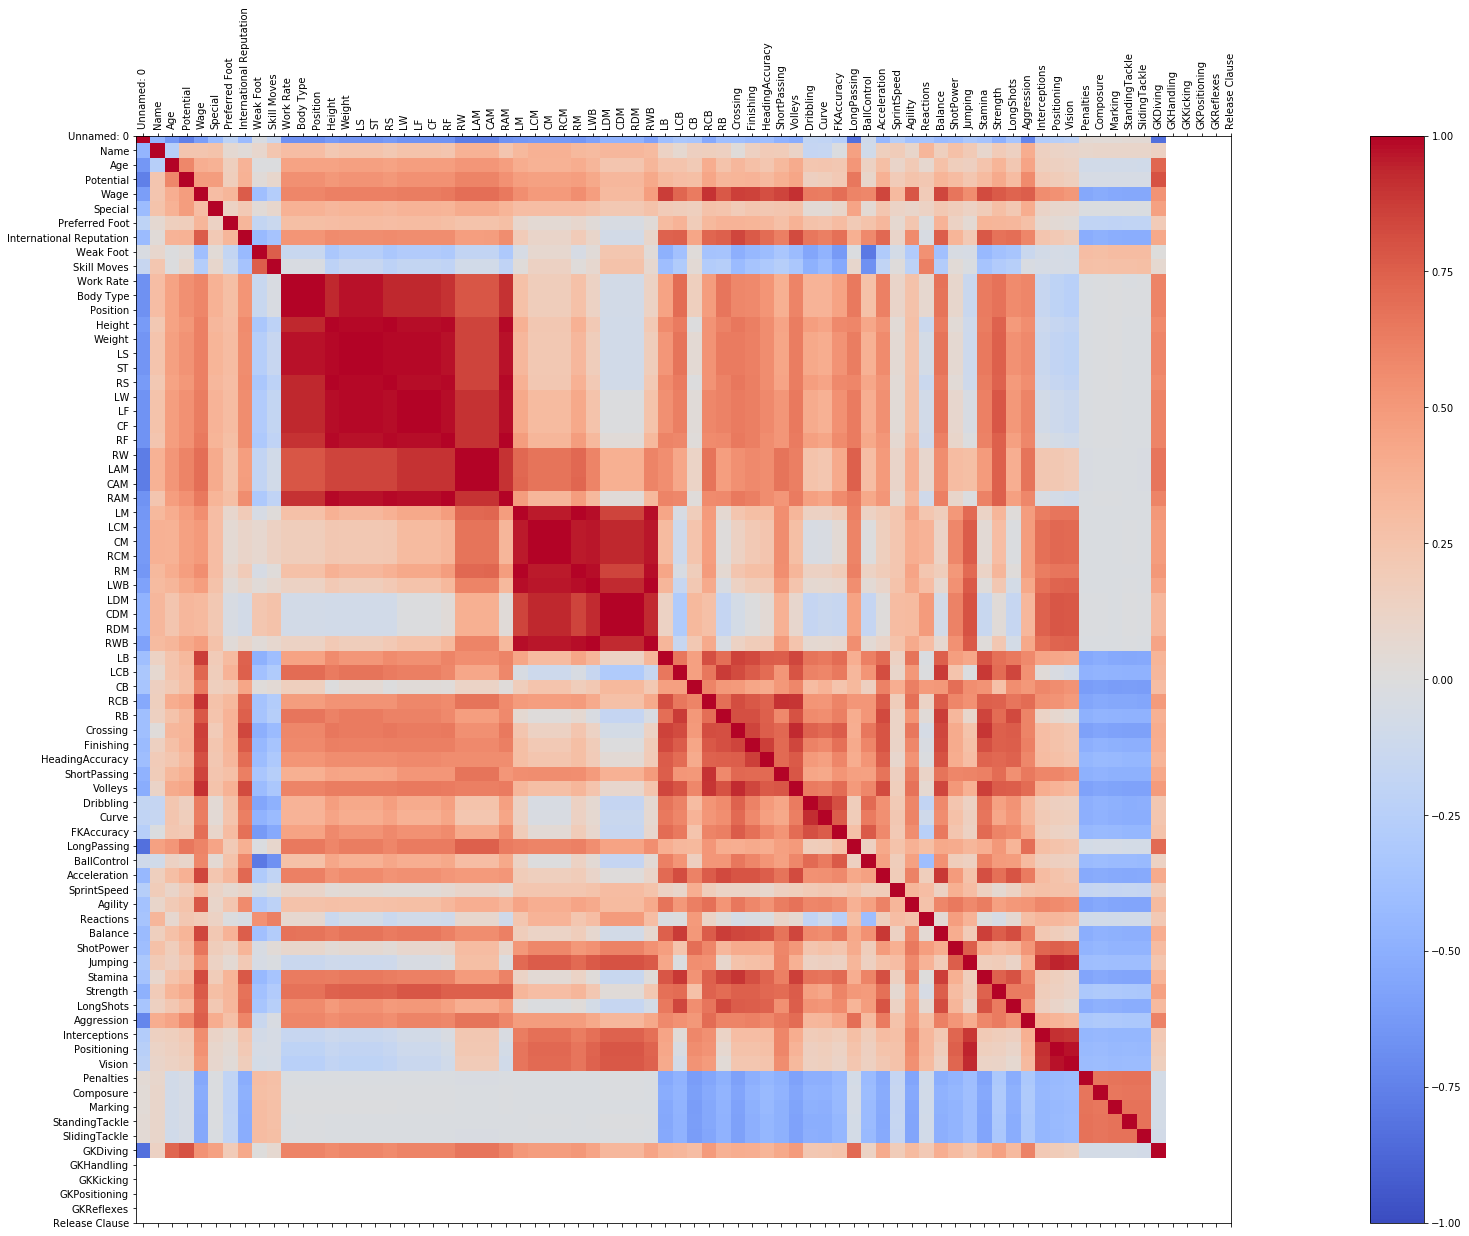

In [40]:
#Now that null values are taken care of I'll look into correlation between
#variables to determine which variables are less important
corr = X.corr()
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

In [41]:
#removing any variables that are too highly correlated
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
#looking at this I'll make a new heatmap with these variables to see what I'll drop

['ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'ShortPassing', 'LongPassing', 'BallControl', 'SprintSpeed', 'StandingTackle', 'SlidingTackle']


In [42]:
drop_list = ['Skill Moves', 'Weight', 'ST', 'RS', 'LW', 'LF', 
              'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 
              'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 
              'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'ShortPassing', 
              'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 
              'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 
              'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 
              'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 
              'StandingTackle', 'SlidingTackle', 'Release Clause', 'value_overall']

In [43]:

print(np.abs(fifa19[drop_list].iloc[:, :].corr(
).loc[:, 'value_overall'].sort_values(ascending=True))
)
# looking at corr of variables that could be dropped

CM                0.443688
LCM               0.443688
RCM               0.443028
Composure         0.418209
LM                0.410983
RM                0.410983
Release Clause    0.408318
RS                0.408085
ST                0.408085
BallControl       0.407064
LAM               0.402352
CAM               0.402352
RAM               0.402352
CF                0.396776
RF                0.396776
LF                0.396776
ShortPassing      0.396737
RW                0.386092
LW                0.386092
RWB               0.354848
ShotPower         0.347420
Dribbling         0.346669
LongPassing       0.342515
Stamina           0.332971
LongShots         0.330237
RDM               0.327802
CDM               0.327802
LDM               0.327802
Vision            0.325986
Skill Moves       0.324458
Curve             0.317767
Crossing          0.312665
LB                0.311360
RB                0.311360
Positioning       0.309416
Volleys           0.305386
Penalties         0.288329
S

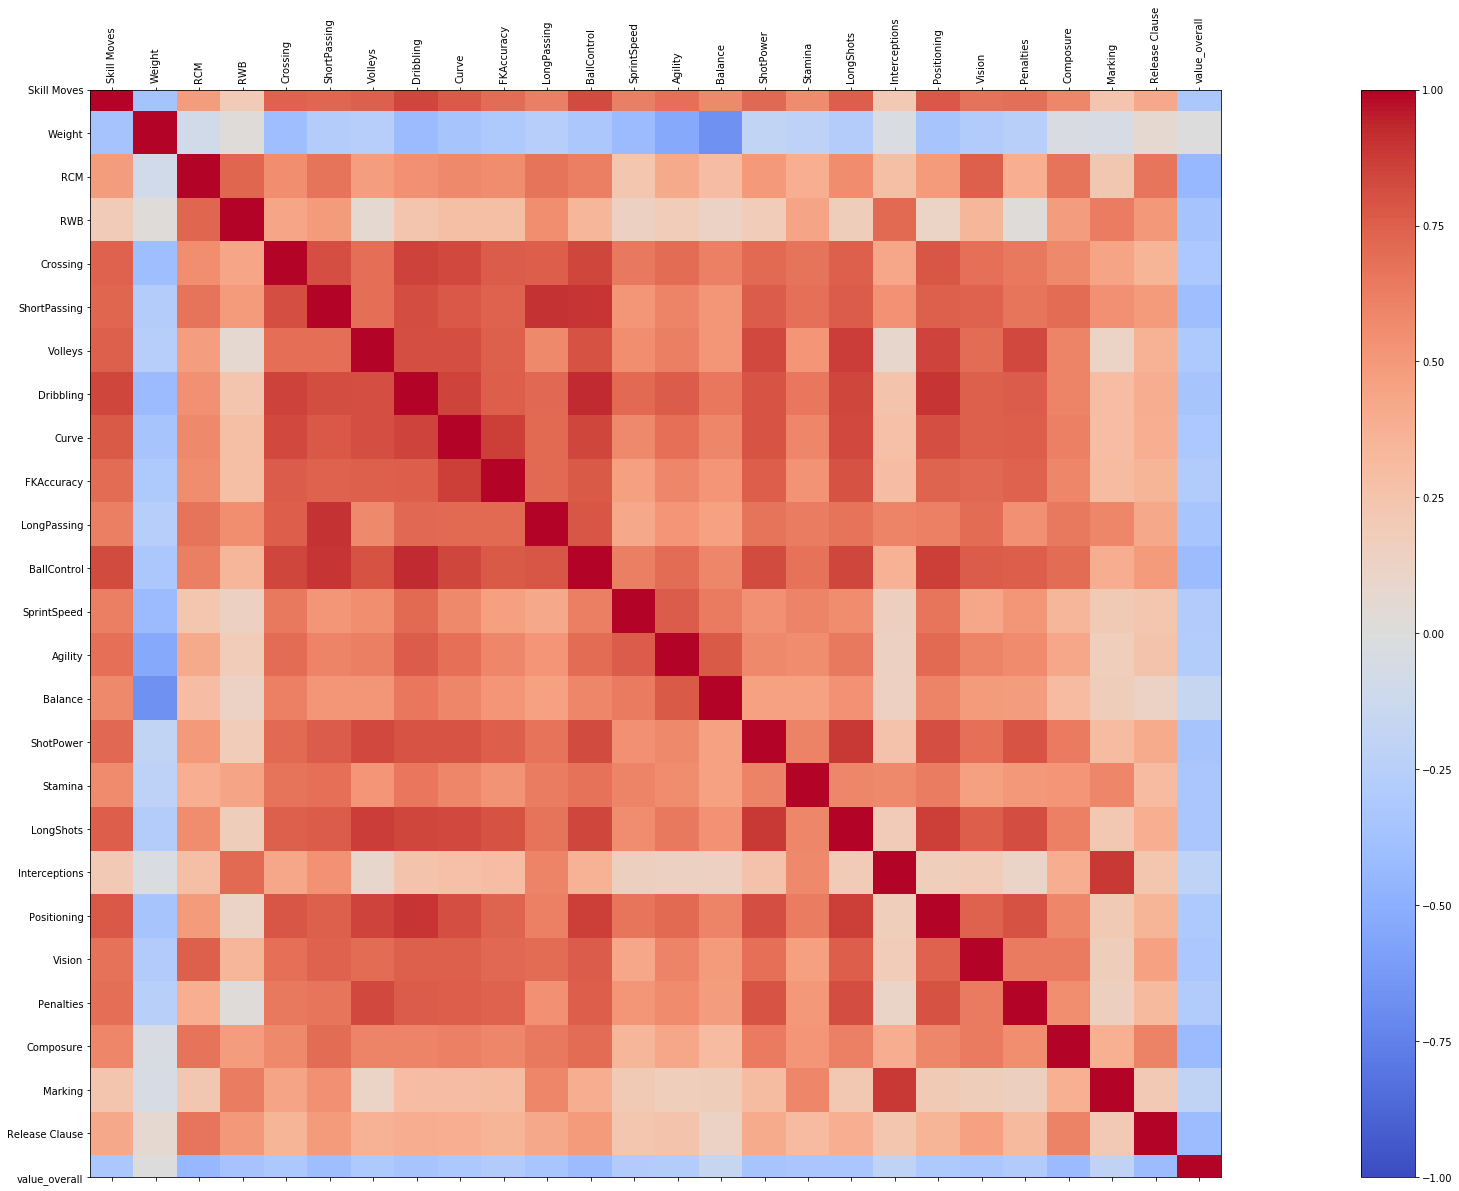

['Skill Moves', 'Weight', 'RCM', 'RWB', 'Crossing', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'Release Clause', 'value_overall']


In [47]:
corr = fifa19[drop_list].corr()
fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(fifa19[drop_list].columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(fifa19[drop_list].columns)
ax.set_yticklabels(fifa19[drop_list].columns)
plt.show()
drop = ['ST', 'RS', 'LW', 'LF', 'CF', 'RF',
        'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
        'CM', 'RM', 'LDM', 'CDM', 'RDM', 'LB',
        'LCB', 'CB', 'RCB', 'RB', 'StandingTackle', 'SlidingTackle']
drop_list = [ele for ele in drop_list if ele not in drop]
print(drop_list)

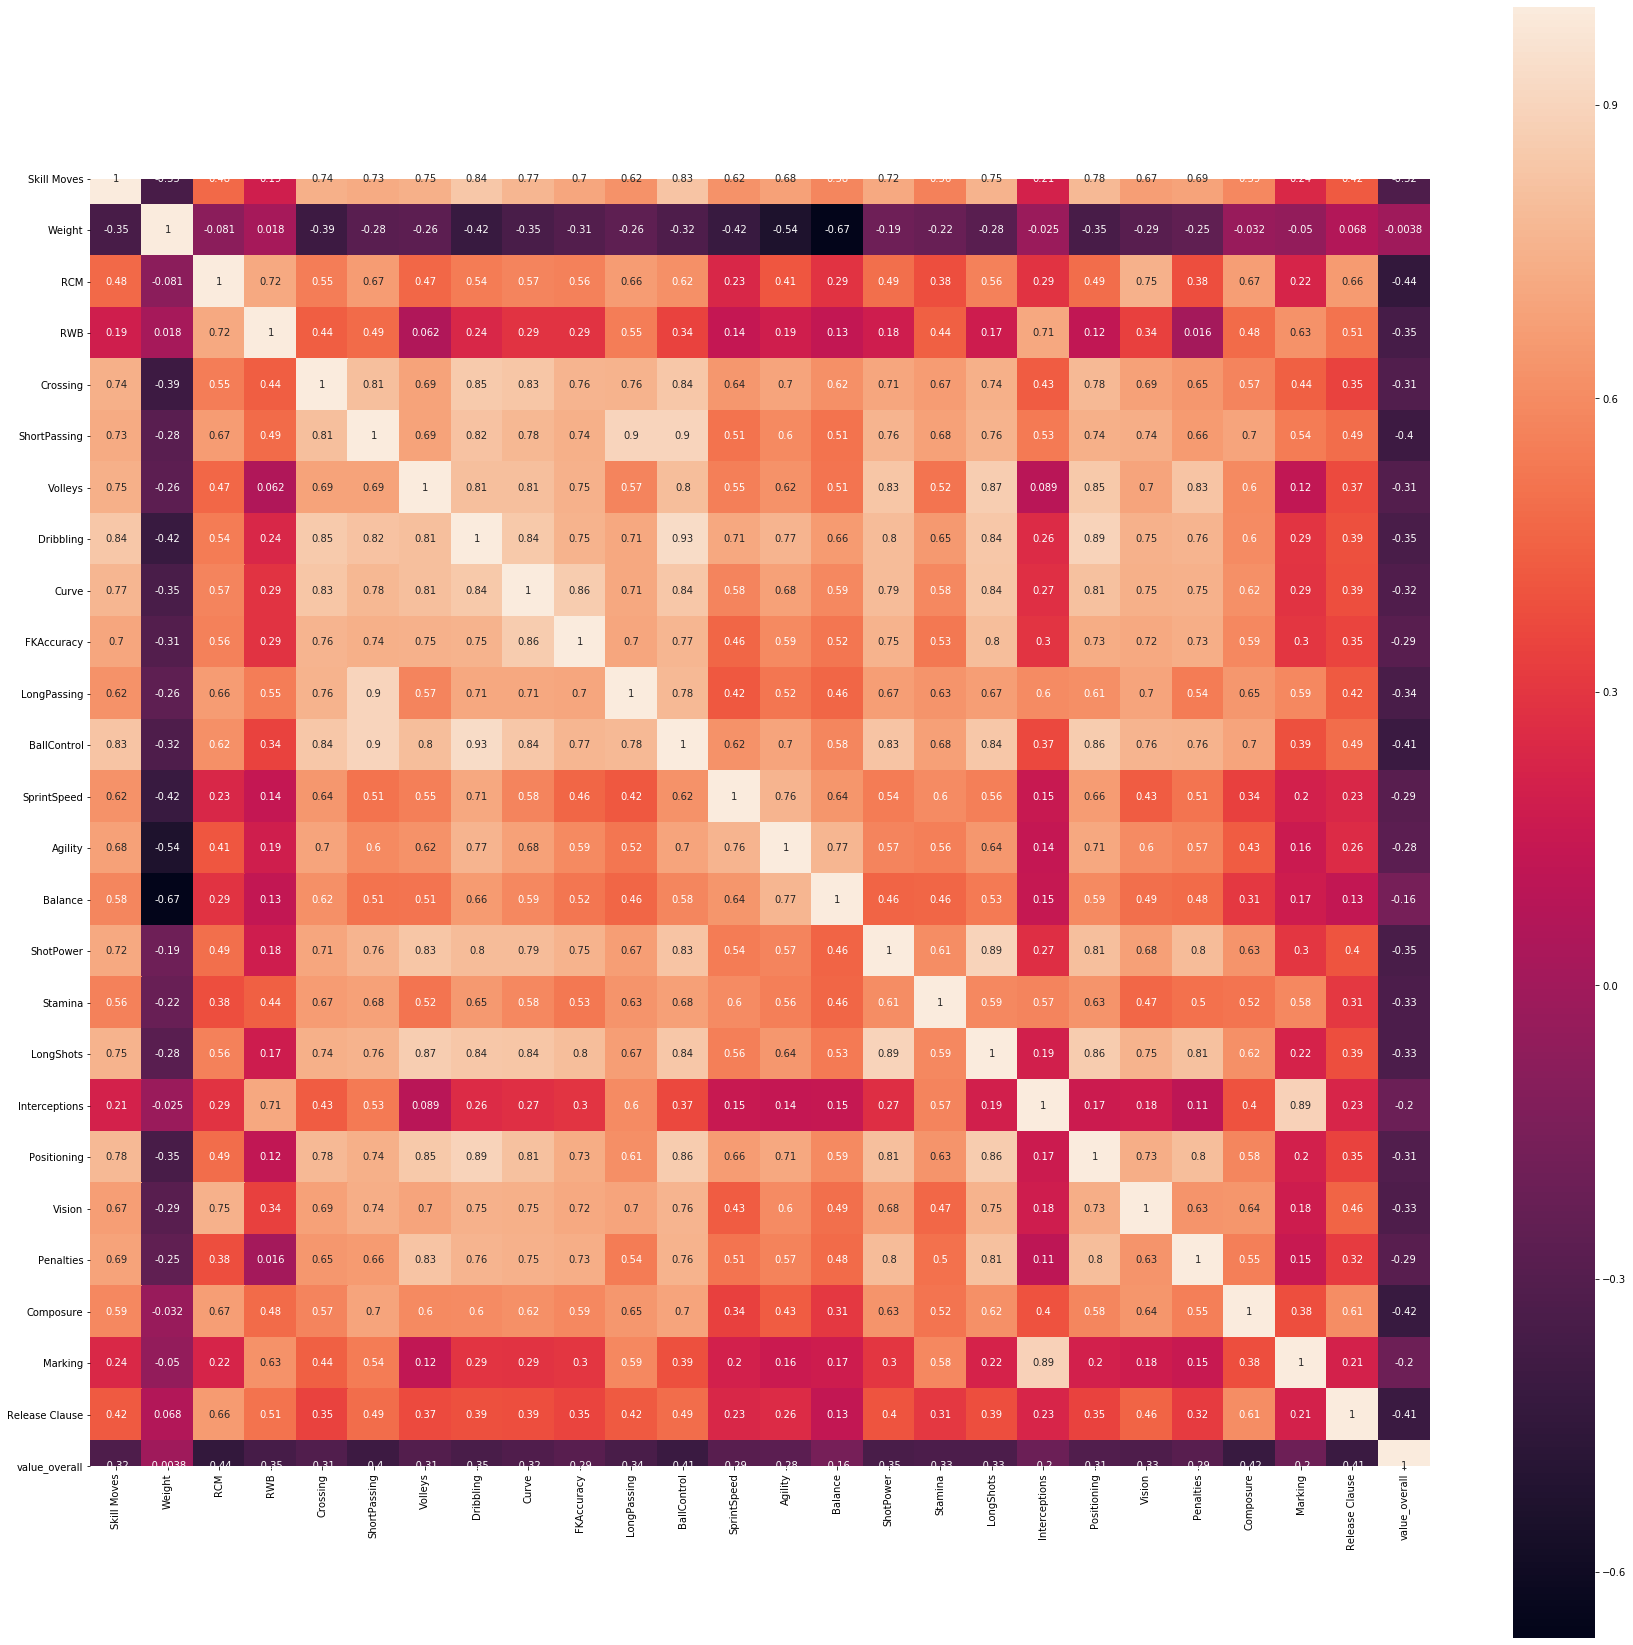

In [48]:
plt.figure(figsize=(30,30))
sns.heatmap(corr, square=True, annot=True)

In [49]:
## I've dropped all the columns with over 90% correlation to each other. 

In [50]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
X = X.drop(columns=drop)
y = fifa19['value_overall']
print(X.columns)

Index(['Unnamed: 0', 'Name', 'Age', 'Potential', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight',
       'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')


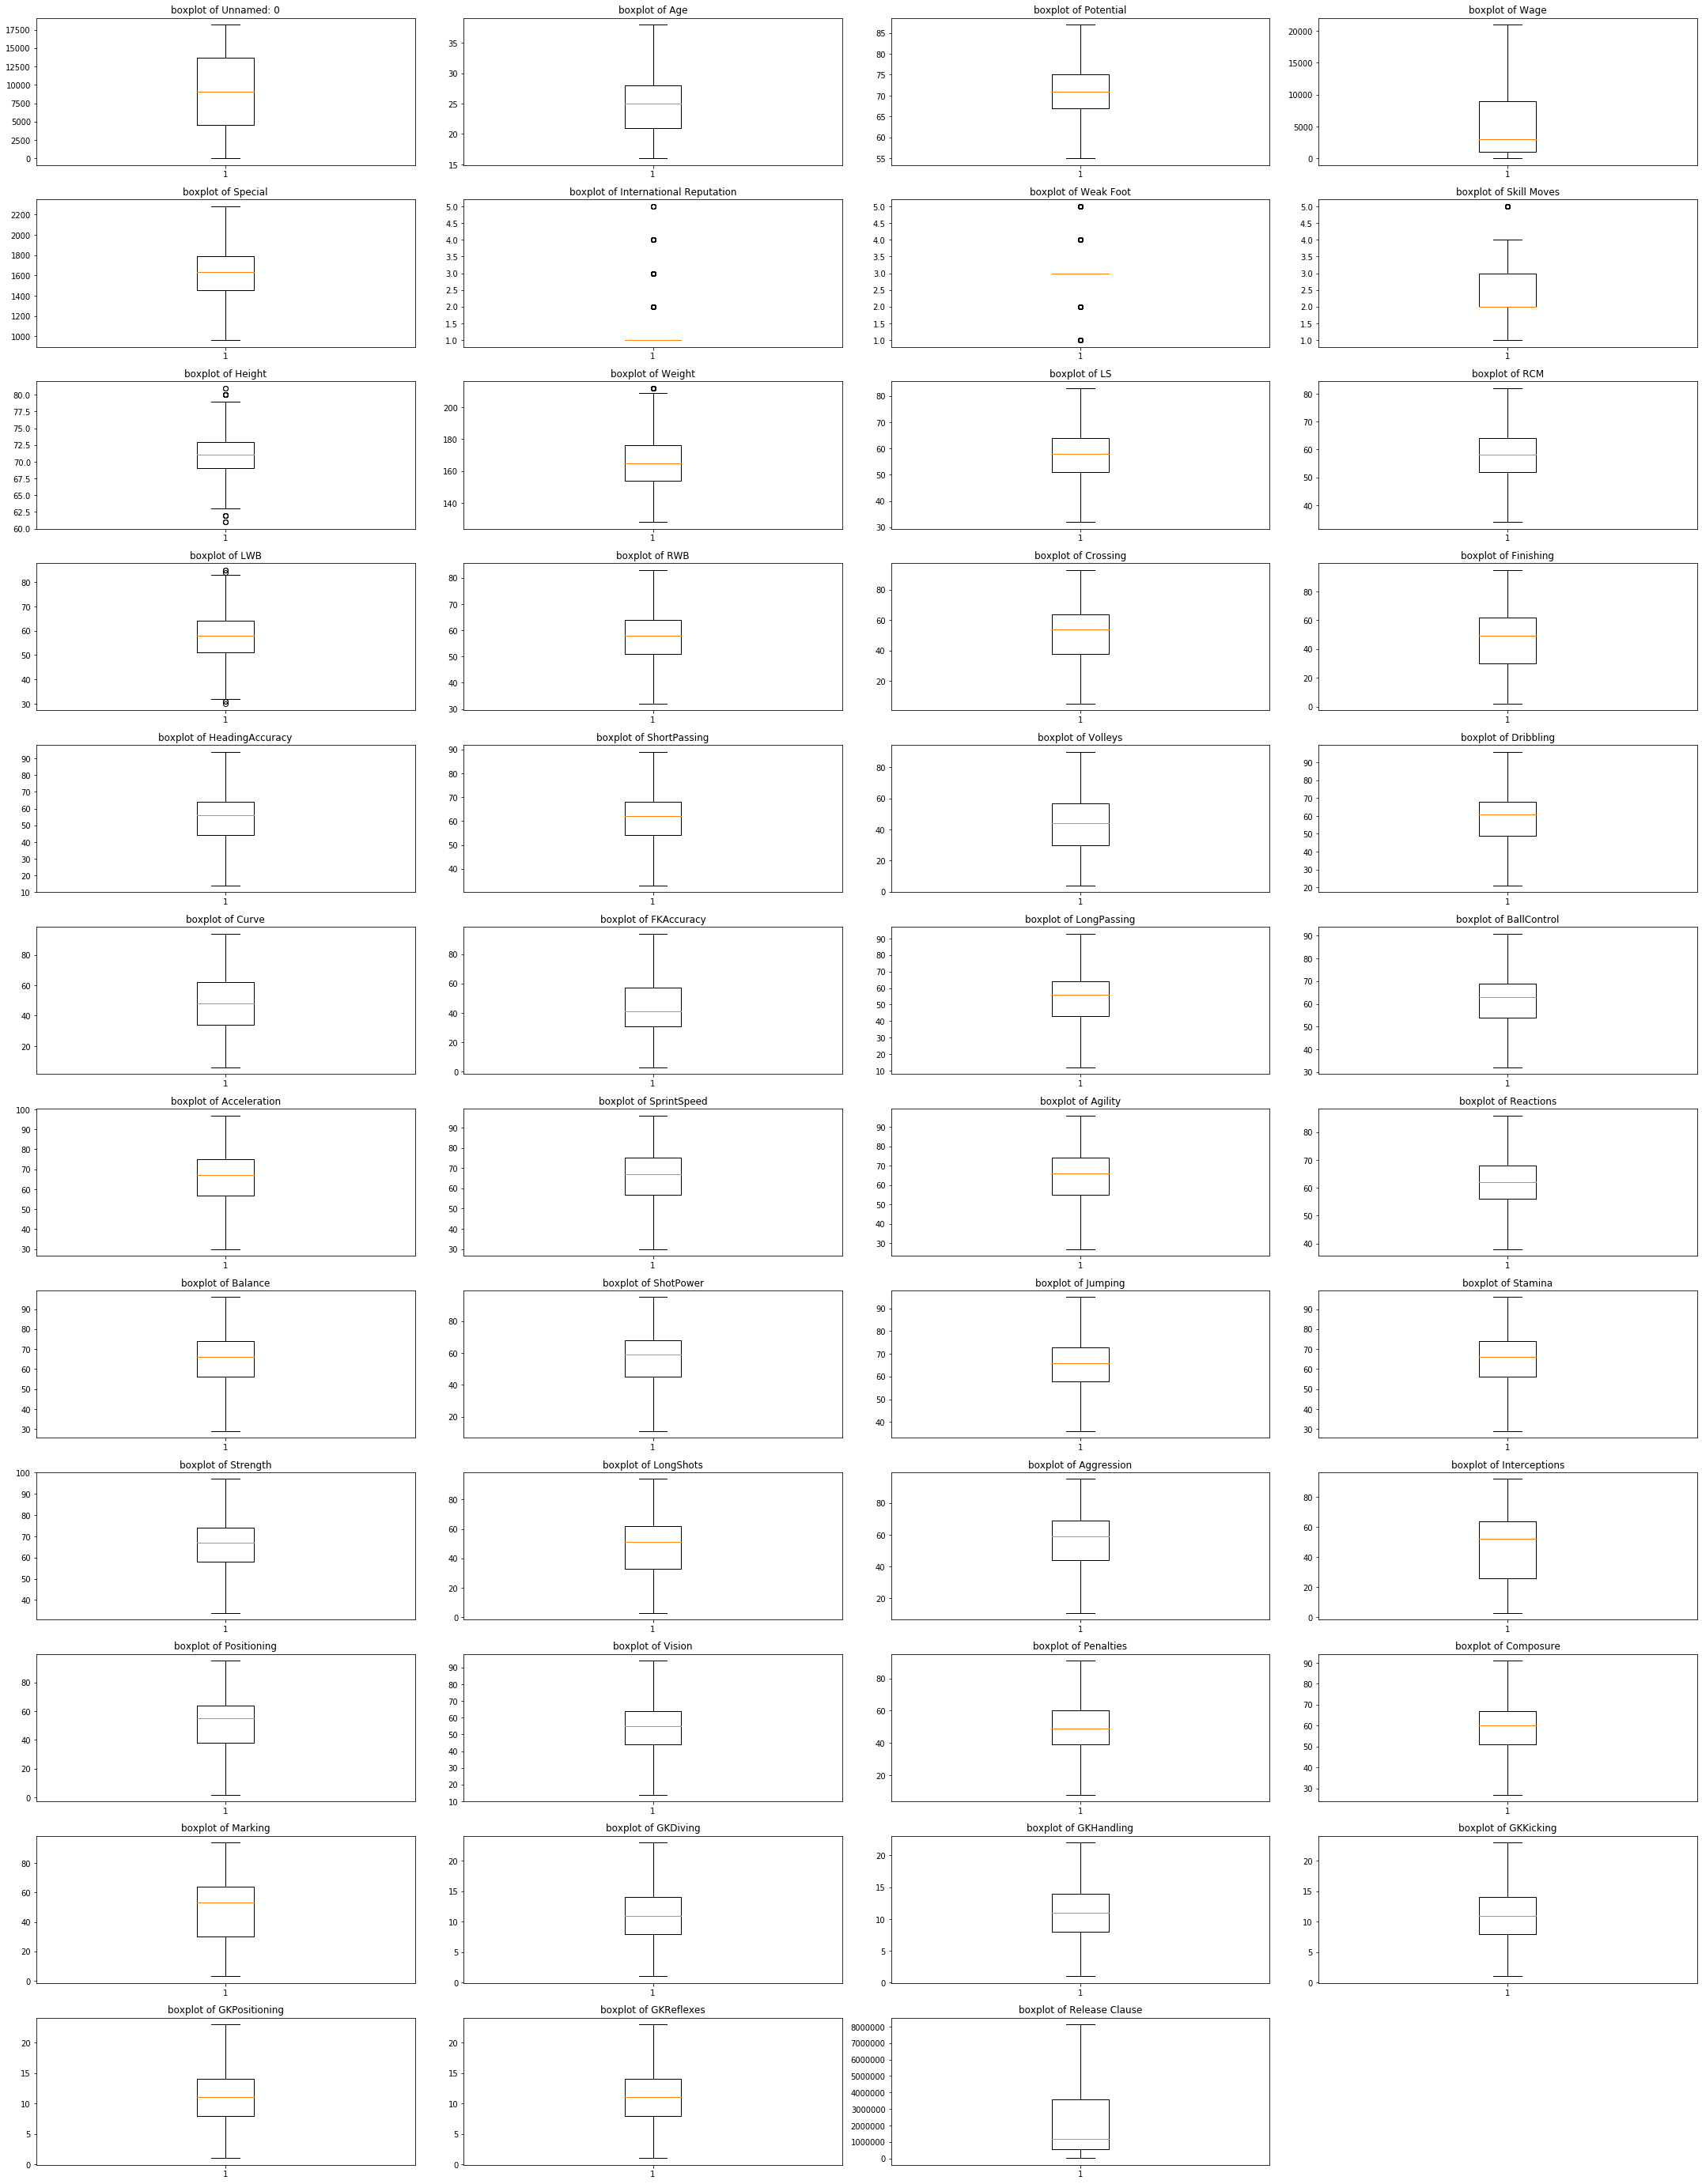

In [51]:
X_cont = X.select_dtypes(exclude='object')
fig = plt.figure(figsize=(30,150))
for i, col in enumerate(X_cont.columns):
    
    plt.subplot(len(X_cont.columns), 4, i+1)
    plt.boxplot(X[col])
    plt.title('boxplot of {}'.format(col))
    plt.tight_layout()


In [52]:
#Looks like I left Name and Unnamed: 0 in there. I'll drop that now
X = X.drop(columns=['Name', 'Unnamed: 0'])

print(list(X.columns))

['Age', 'Potential', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight', 'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']


## getting dummies for X

In [53]:
# Get dummies for X
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)
# X head
X.head()

,Age,Potential,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,...,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST
0,31,87,21000.0,2202,5.0,4.0,4.0,67.0,159.0,83.0,...,0,0,0,0,1,0,0,0,0,0
1,33,87,21000.0,2228,5.0,4.0,5.0,74.0,183.0,83.0,...,0,0,0,0,0,0,0,0,0,1
2,26,87,21000.0,2143,5.0,5.0,5.0,69.0,150.0,83.0,...,0,0,0,0,0,0,0,0,0,0
3,27,87,21000.0,1471,4.0,3.0,1.0,76.0,168.0,83.0,...,0,0,0,0,0,0,0,0,0,0
4,27,87,21000.0,2281,4.0,5.0,4.0,71.0,154.0,82.0,...,0,0,1,0,0,0,0,0,0,0


In [54]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
print(X_train.shape)
print(X_test.shape)


#X = scaler.fit_transform(X)
y = fifa19['value_overall']

(13610, 90)
(4537, 90)


The number of observations in training set is 13610
The number of observations in test set is 4537


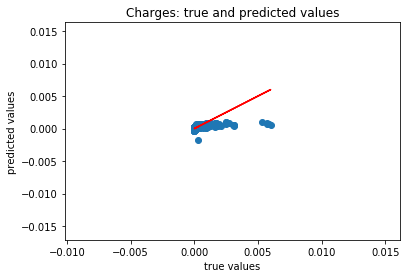

Mean absolute error of the prediction is: 9.567548258100265e-05
Mean squared error of the prediction is: 5.529557656336706e-08
Root mean squared error of the prediction is: 0.0002351501149550369
Mean absolute percentage error of the prediction is: 320.6121992458001


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.571
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                              267.4
Date:                Tue, 31 Dec 2019   Prob (F-statistic):                        0.00
Time:                        10:35:56   Log-Likelihood:                      1.2800e+05
No. Observations:               18147   AIC:                                 -2.558e+05
Df Residuals:                   18057   BIC:                                 -2.551e+05
Df Model:                          90                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                            7.772e-06   6.45e-07     12.044      0.000    6.51e-06    9.04e-06
Potential                     -1.317e-05   5.37e-07    -24.532      0.000   -1.42e-05   -1.21e-05
Wage                           4.904e-10   4.06e-10      1.208      0.227   -3.05e-10    1.29e-09
Special                        3.249e-07   1.21e-07      2.687      0.007    8.79e-08    5.62e-07
International Reputation       7.687e-05   4.87e-06     15.794      0.000    6.73e-05    8.64e-05
Weak Foot                      8.677e-07    2.6e-06      0.334      0.739   -4.23e-06    5.97e-06
Skill Moves                    6.797e-06   4.29e-06      1.585      0.113   -1.61e-06    1.52e-05
Height                         3.692e-06   1.16e-06      3.181      0.001    1.42e-06    5.97e-06
Weight                        -1.896e-07   1.86e-07     -1.018      0.309   -5.55e-07    1.75e-07
LS                            -1.525e-05   1.16e-06    -13.103      0.000   -1.75e-05    -1.3e-05
RCM                           -1.109e-06   1.46e-06     -0.759      0.448   -3.97e-06    1.75e-06
LWB                           -2.572e-05   5.44e-05     -0.472      0.637      -0.000     8.1e-05
RWB                            1.171e-05   5.44e-05      0.215      0.830    -9.5e-05       0.000
Crossing                       9.818e-07   2.71e-07      3.620      0.000     4.5e-07    1.51e-06
Finishing                      1.992e-06   3.27e-07      6.086      0.000    1.35e-06    2.63e-06
HeadingAccuracy               -2.245e-07    2.8e-07     -0.802      0.423   -7.74e-07    3.24e-07
ShortPassing                  -5.167e-07   4.59e-07     -1.125      0.261   -1.42e-06    3.84e-07
Volleys                       -2.838e-07   2.57e-07     -1.106      0.269   -7.87e-07    2.19e-07
Dribbling                      1.725e-06   3.75e-07      4.597      0.000    9.89e-07    2.46e-06
Curve                         -2.421e-07   2.58e-07     -0.940      0.347   -7.47e-07    2.63e-07
FKAccuracy                     -4.81e-07   2.38e-07     -2.021      0.043   -9.48e-07   -1.44e-08
LongPassing                   -3.694e-07   3.66e-07     -1.009      0.313   -1.09e-06    3.48e-07
BallControl                   -1.663e-06   4.67e-07     -3.559      0.000   -2.58e-06   -7.47e-07
Acceleration                  -2.583e-07   3.43e-07     -0.753      0.451   -9.31e-07    4.14e-07
SprintSpeed                     3.92e-07   3.22e-07      1.218      0.223   -2.39e-07    1.02e-06
Agility                       -1.166e-06   2.63e-07     -4.438      0.000   -1.68e-06   -6.51e-07
Reactions                     -3.837e-06    3.6e-07    -10.665      0.000   -4.54e-06   -3.13e-06
Balance                        5.417e-07   2

In [55]:
y = fifa19['value_overall']
#starting with OLS
results = sm.OLS(y, X).fit()



print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)


# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())


## That model is not great with an adjusted R-squared value of 0.569. I'll log transform my y variable and try again

## I am also interested in knowing the time to run these algorithms as well as the performance so I'll use a log time function

In [56]:
# function 
import atexit
from time import time, strftime, localtime
from datetime import timedelta

def secondsToStr(elapsed=None):
    if elapsed is None:
        return strftime("%Y-%m-%d %H:%M:%S", localtime())
    else:
        return str(timedelta(seconds=elapsed))

def log(s, elapsed=None):
    line = "="*40
    print(line)
    print(secondsToStr(), '-', s)
    if elapsed:
        print("Elapsed time:", elapsed)
    print(line)
    print()

def endlog():
    end = time()
    elapsed = end-start
    log("End Program", secondsToStr(elapsed))

## Log transform y to hopefully get some better results

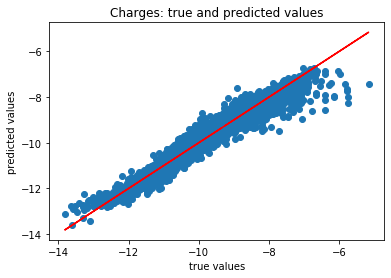

Mean absolute error of the prediction is: 0.2387053101404087
Mean squared error of the prediction is: 0.10382327078515645
Root mean squared error of the prediction is: 0.3222161864108575
Mean absolute percentage error of the prediction is: 2.640149799576299


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     3079.
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:36:33   Log-Likelihood:                -5260.9
No. Observations:               18147   AIC:                         1.070e+04
Df Residuals:                   18056   BIC:                         1.141e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.5155      0.361      1.430      0.153      -0.191       1.222
Age                               0.0097      0.001      9.645      0.000       0.008       0.012
Potential                        -0.0518      0.001    -61.623      0.000      -0.053      -0.050
Wage                          -6.311e-06   6.28e-07    -10.048      0.000   -7.54e-06   -5.08e-06
Special                           0.0005      0.000      2.814      0.005       0.000       0.001
International Reputation         -0.0041      0.008     -0.549      0.583      -0.019       0.011
Weak Foot                        -0.0036      0.004     -0.888      0.375      -0.011       0.004
Skill Moves                      -0.0707      0.007    -10.671      0.000      -0.084      -0.058
Height                            0.0003      0.002      0.149      0.882      -0.003       0.004
Weight                           -0.0012      0.000     -4.208      0.000      -0.002      -0.001
LS                               -0.0276      0.002    -15.323      0.000      -0.031      -0.024
RCM                              -0.0064      0.002     -2.837      0.005      -0.011      -0.002
LWB                              -0.1518      0.084     -1.804      0.071      -0.317       0.013
RWB                               0.1275      0.084      1.515      0.130      -0.037       0.292
Crossing                          0.0026      0.000      6.107      0.000       0.002       0.003
Finishing                         0.0023      0.001      4.606      0.000       0.001       0.003
HeadingAccuracy                  -0.0020      0.000     -4.524      0.000      -0.003      -0.001
ShortPassing                     -0.0058      0.001     -8.126      0.000      -0.007      -0.004
Volleys                          -0.0003      0.000     -0.760      0.447      -0.001       0.000
Dribbling                         0.0042      0.001      7.301      0.000       0.003       0.005
Curve                          5.543e-05      0.000      0.139      0.889      -0.001       0.001
FKAccuracy                       -0.0016      0.000     -4.329      0.000      -0.002      -0.001
LongPassing                       0.0009      0.001      1.543      0.123      -0.000       0.002
BallControl                      -0.0088      0.001    -12.210      0.000      -0.010      -0.007
Acceleration                     -0.0023      0.001     -4.288      0.000      -0.003      -0.001
SprintSpeed                      -0.0014      0.000     -2.910      0.004      -0.002      -0.000
Agility                          -0.0021      0.000     -5.206      0.000      -0.003      -0.001
Reactions                        -0.0153      0.001    -27.550      0.000      -0.016      -0.014
Balance                           0.0006     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     118.8
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:36:33   Log-Likelihood:                 96645.
No. Observations:               13610   AIC:                        -1.931e+05
Df Residuals:                   13523   BIC:                        -1.925e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                            6.303e-06   7.18e-07      8.779      0.000     4.9e-06    7.71e-06
Potential                     -1.384e-05   5.97e-07    -23.174      0.000    -1.5e-05   -1.27e-05
Wage                           7.422e-10   4.49e-10      1.653      0.098   -1.38e-10    1.62e-09
Special                        3.498e-07   1.34e-07      2.620      0.009    8.81e-08    6.12e-07
International Reputation       7.396e-05   5.43e-06     13.609      0.000    6.33e-05    8.46e-05
Weak Foot                     -3.258e-07   2.86e-06     -0.114      0.909   -5.94e-06    5.29e-06
Skill Moves                    6.069e-06   4.73e-06      1.282      0.200   -3.21e-06    1.53e-05
Height                         6.922e-07   1.34e-06      0.516      0.606   -1.94e-06    3.32e-06
Weight                        -4.351e-07   2.06e-07     -2.111      0.035   -8.39e-07   -3.11e-08
LS                            -1.442e-05    1.3e-06    -11.086      0.000    -1.7e-05   -1.19e-05
RCM                            4.568e-08   1.64e-06      0.028      0.978   -3.17e-06    3.26e-06
LWB                            9.926e-05      0.000      0.986      0.324    -9.8e-05       0.000
RWB                              -0.0001      0.000     -1.123      0.261      -0.000    8.42e-05
Crossing                       9.682e-07   2.98e-07      3.249      0.001    3.84e-07    1.55e-06
Finishing                      1.765e-06    3.6e-07      4.900      0.000    1.06e-06    2.47e-06
HeadingAccuracy               -2.813e-07   3.11e-07     -0.905      0.365    -8.9e-07    3.28e-07
ShortPassing                  -6.867e-07    5.1e-07     -1.348      0.178   -1.69e-06    3.12e-07
Volleys                       -2.676e-07   2.82e-07     -0.949      0.343   -8.21e-07    2.85e-07
Dribbling                      1.506e-06   4.13e-07      3.648      0.000    6.97e-07    2.32e-06
Curve                         -1.072e-07   2.83e-07     -0.379      0.705   -6.62e-07    4.48e-07
FKAccuracy                    -6.132e-07   2.62e-07     -2.338      0.019   -1.13e-06   -9.91e-08
LongPassing                     -3.7e-07   4.08e-07     -0.907      0.364   -1.17e-06     4.3e-07
BallControl                   -2.127e-06   5.15e-07     -4.131      0.000   -3.14e-06   -1.12e-06
Acceleration                   1.981e-07   3.77e-07      0.525      0.600   -5.42e-07    9.38e-07
SprintSpeed                   -1.102e-07   3.56e-07     -0.309      0.757   -8.08e-07    5.88e-07
Agility                       -1.131e-06   2.89e-07     -3.911      0.000    -1.7e-06   -5.64e-07
Reactions                     -4.025e-06   3.96e-07    -10.177      0.000    -4.8e-06   -3.25e-06
Balance                       -2.165e-07   2.93e-07     -0.739      0.460   -7.91e-07    3.58e-07
ShotPower                      2.697e-07   3.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              59.40
Date:                Tue, 31 Dec 2019   Prob (F-statistic):                        0.00
Time:                        10:36:33   Log-Likelihood:                          31508.
No. Observations:                4537   AIC:                                 -6.284e+04
Df Residuals:                    4450   BIC:                                 -6.228e+04
Df Model:                          87                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                            1.147e-05   1.44e-06      7.976      0.000    8.65e-06    1.43e-05
Potential                     -1.215e-05    1.2e-06    -10.141      0.000   -1.45e-05    -9.8e-06
Wage                            9.31e-11   9.13e-10      0.102      0.919    -1.7e-09    1.88e-09
Special                        1.976e-07   2.71e-07      0.728      0.466   -3.34e-07    7.29e-07
International Reputation       8.433e-05   1.07e-05      7.910      0.000    6.34e-05       0.000
Weak Foot                       4.64e-06   5.91e-06      0.786      0.432   -6.94e-06    1.62e-05
Skill Moves                    8.723e-06   9.68e-06      0.901      0.368   -1.03e-05    2.77e-05
Height                         6.964e-06   2.41e-06      2.889      0.004    2.24e-06    1.17e-05
Weight                         5.596e-07   4.16e-07      1.346      0.178   -2.55e-07    1.37e-06
LS                            -1.772e-05   2.53e-06     -7.014      0.000   -2.27e-05   -1.28e-05
RCM                           -3.829e-06   3.14e-06     -1.221      0.222   -9.98e-06    2.32e-06
LWB                           -8.115e-05   7.22e-05     -1.124      0.261      -0.000    6.04e-05
RWB                            6.635e-05   7.22e-05      0.919      0.358   -7.52e-05       0.000
Crossing                       1.035e-06   6.19e-07      1.672      0.095   -1.78e-07    2.25e-06
Finishing                      2.693e-06   7.44e-07      3.620      0.000    1.23e-06    4.15e-06
HeadingAccuracy                9.395e-08   6.24e-07      0.151      0.880   -1.13e-06    1.32e-06
ShortPassing                  -2.253e-07   1.02e-06     -0.221      0.825   -2.22e-06    1.77e-06
Volleys                       -2.355e-07   5.85e-07     -0.402      0.687   -1.38e-06    9.12e-07
Dribbling                      2.453e-06   8.53e-07      2.875      0.004     7.8e-07    4.13e-06
Curve                          -6.46e-07   5.89e-07     -1.096      0.273    -1.8e-06     5.1e-07
FKAccuracy                    -7.175e-08    5.4e-07     -0.133      0.894   -1.13e-06    9.86e-07
LongPassing                   -2.835e-07   8.04e-07     -0.353      0.724   -1.86e-06    1.29e-06
BallControl                   -4.847e-07   1.06e-06     -0.457      0.647   -2.56e-06    1.59e-06
Acceleration                  -1.676e-06   7.79e-07     -2.152      0.031    -3.2e-06   -1.49e-07
SprintSpeed                    2.113e-06   7.18e-07      2.941      0.003    7.05e-07    3.52e-06
Agility                       -1.234e-06   5.96e-07     -2.071      0.038    -2.4e-06   -6.56e-08
Reactions                     -3.471e-06   8.22e-07     -4.226      0.000   -5.08e-06   -1.86e-06
Balance                        2.208e-06   5

2019-12-31 10:36:34 - OLS
Elapsed time: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c25d20240>

2019-12-31 10:36:34 - End Program
Elapsed time: 0:00:00.218844



In [57]:
# y variable is now log transformed
y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results_train = sm.OLS(y_train, X_train).fit()
results_test = sm.OLS(y_test, X_test).fit()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())
display(results_train.summary())
display(results_test.summary())

#checking time to run model
start = time()
atexit.register(endlog)
log('OLS', sm.OLS(y,X).fit())
endlog()


## some variables have very high p values. I am going to start with dropping all p values over .100. Run time is almost 1/10th of a second. But with and adjusted r-squared score of .939 I think that this model is performing quite well.

In [58]:
high_pval = ['Special', 'Weak Foot', 'Height', 'LS', 'RCM', 'LWB', 'RWB',
             'RWB', 'Crossing', 'Finishing', 'Volleys', 'Dribbling',
             'Curve', 'FKAccuracy', 'LongPassing', 'ShotPower', 'Jumping',
             'LongShots', 'Aggression', 'Penalties', 'GKHandling', 'GKKicking',
             'GKPositioning', 'Position_LAM', 'Position_LM', 'Position_LW',
             'Position_RF', 'Position_RM', 'Position_RS', 'Position_RW',
             'Position_ST']

In [59]:
X = X.drop(columns=high_pval)

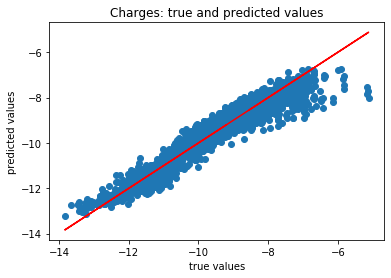

Mean absolute error of the prediction is: 0.2526155060386059
Mean squared error of the prediction is: 0.11936175874794147
Root mean squared error of the prediction is: 0.34548771142826695
Mean absolute percentage error of the prediction is: 2.8244708713955338


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     4193.
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:37:07   Log-Likelihood:                -6095.6
No. Observations:               18147   AIC:                         1.231e+04
Df Residuals:                   18086   BIC:                         1.279e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.0459      0.357      2.926      0.003       0.345       1.747
Age                              -0.0013      0.001     -1.344      0.179      -0.003       0.001
Potential                        -0.0617      0.001    -73.881      0.000      -0.063      -0.060
Wage                          -6.896e-06   6.54e-07    -10.542      0.000   -8.18e-06   -5.61e-06
International Reputation          0.0060      0.008      0.773      0.440      -0.009       0.021
Skill Moves                      -0.0487      0.007     -7.311      0.000      -0.062      -0.036
Weight                           -0.0015      0.000     -5.538      0.000      -0.002      -0.001
HeadingAccuracy                  -0.0028      0.000     -7.976      0.000      -0.003      -0.002
ShortPassing                     -0.0076      0.001    -13.444      0.000      -0.009      -0.006
BallControl                      -0.0103      0.001    -16.053      0.000      -0.012      -0.009
Acceleration                     -0.0037      0.001     -7.090      0.000      -0.005      -0.003
SprintSpeed                      -0.0040      0.000     -8.264      0.000      -0.005      -0.003
Agility                          -0.0021      0.000     -5.654      0.000      -0.003      -0.001
Reactions                        -0.0220      0.001    -40.597      0.000      -0.023      -0.021
Balance                           0.0016      0.000      4.590      0.000       0.001       0.002
Stamina                          -0.0070      0.000    -22.150      0.000      -0.008      -0.006
Strength                         -0.0053      0.000    -14.763      0.000      -0.006      -0.005
Interceptions                    -0.0005      0.000     -1.402      0.161      -0.001       0.000
Positioning                       0.0002      0.000      0.657      0.511      -0.000       0.001
Vision                           -0.0001      0.000     -0.358      0.720      -0.001       0.001
Composure                        -0.0037      0.000     -8.721      0.000      -0.005      -0.003
Marking                          -0.0016      0.000     -5.024      0.000      -0.002      -0.001
GKDiving                         -0.0033      0.001     -3.741      0.000      -0.005      -0.002
GKReflexes                       -0.0031      0.001     -3.526      0.000      -0.005      -0.001
Release Clause                -1.826e-07   1.98e-09    -92.051      0.000   -1.86e-07   -1.79e-07
Preferred Foot_Right              0.0253      0.007      3.674      0.000       0.012       0.039
Work Rate_High/ Low              -0.0993      0.017     -5.709      0.000      -0.133      -0.065
Work Rate_High/ Medium           -0.0439      0.013     -3.494      0.000      -0.069      -0.019
Work Rate_Low/ High              -0.0805     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     3180.
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:37:07   Log-Likelihood:                -4471.3
No. Observations:               13610   AIC:                             9065.
Df Residuals:                   13549   BIC:                             9523.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.2019      0.362      3.322      0.001       0.493       1.911
Age                              -0.0025      0.001     -2.228      0.026      -0.005      -0.000
Potential                        -0.0622      0.001    -64.881      0.000      -0.064      -0.060
Wage                          -6.793e-06   7.49e-07     -9.064      0.000   -8.26e-06   -5.32e-06
International Reputation         -0.0019      0.009     -0.211      0.833      -0.019       0.016
Skill Moves                      -0.0453      0.008     -5.929      0.000      -0.060      -0.030
Weight                           -0.0016      0.000     -5.258      0.000      -0.002      -0.001
HeadingAccuracy                  -0.0027      0.000     -6.875      0.000      -0.004      -0.002
ShortPassing                     -0.0075      0.001    -11.634      0.000      -0.009      -0.006
BallControl                      -0.0109      0.001    -14.825      0.000      -0.012      -0.009
Acceleration                     -0.0038      0.001     -6.313      0.000      -0.005      -0.003
SprintSpeed                      -0.0040      0.001     -7.213      0.000      -0.005      -0.003
Agility                          -0.0018      0.000     -4.151      0.000      -0.003      -0.001
Reactions                        -0.0216      0.001    -34.768      0.000      -0.023      -0.020
Balance                           0.0014      0.000      3.360      0.001       0.001       0.002
Stamina                          -0.0072      0.000    -19.851      0.000      -0.008      -0.007
Strength                         -0.0051      0.000    -12.394      0.000      -0.006      -0.004
Interceptions                    -0.0003      0.000     -0.723      0.470      -0.001       0.000
Positioning                       0.0005      0.000      1.080      0.280      -0.000       0.001
Vision                        -7.992e-05      0.000     -0.192      0.848      -0.001       0.001
Composure                        -0.0040      0.000     -8.191      0.000      -0.005      -0.003
Marking                          -0.0015      0.000     -4.272      0.000      -0.002      -0.001
GKDiving                         -0.0037      0.001     -3.683      0.000      -0.006      -0.002
GKReflexes                       -0.0029      0.001     -2.847      0.004      -0.005      -0.001
Release Clause                -1.808e-07   2.28e-09    -79.388      0.000   -1.85e-07   -1.76e-07
Preferred Foot_Right              0.0269      0.008      3.397      0.001       0.011       0.042
Work Rate_High/ Low              -0.0881      0.020     -4.388      0.000      -0.127      -0.049
Work Rate_High/ Medium           -0.0330      0.015     -2.264      0.024      -0.062      -0.004
Work Rate_Low/ High              -0.0650     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1146.
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:37:07   Log-Likelihood:                -1599.3
No. Observations:                4537   AIC:                             3307.
Df Residuals:                    4483   BIC:                             3653.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0105      0.125      0.084      0.933      -0.234       0.255
Age                               0.0020      0.002      1.006      0.314      -0.002       0.006
Potential                        -0.0605      0.002    -35.432      0.000      -0.064      -0.057
Wage                           -6.98e-06   1.35e-06     -5.179      0.000   -9.62e-06   -4.34e-06
International Reputation          0.0293      0.016      1.838      0.066      -0.002       0.061
Skill Moves                      -0.0586      0.014     -4.272      0.000      -0.085      -0.032
Weight                           -0.0012      0.001     -2.024      0.043      -0.002   -3.66e-05
HeadingAccuracy                  -0.0029      0.001     -4.054      0.000      -0.004      -0.001
ShortPassing                     -0.0079      0.001     -6.721      0.000      -0.010      -0.006
BallControl                      -0.0084      0.001     -6.313      0.000      -0.011      -0.006
Acceleration                     -0.0034      0.001     -3.130      0.002      -0.005      -0.001
SprintSpeed                      -0.0039      0.001     -4.004      0.000      -0.006      -0.002
Agility                          -0.0031      0.001     -4.018      0.000      -0.005      -0.002
Reactions                        -0.0234      0.001    -20.821      0.000      -0.026      -0.021
Balance                           0.0024      0.001      3.300      0.001       0.001       0.004
Stamina                          -0.0065      0.001     -9.890      0.000      -0.008      -0.005
Strength                         -0.0059      0.001     -7.820      0.000      -0.007      -0.004
Interceptions                    -0.0011      0.001     -1.618      0.106      -0.002       0.000
Positioning                      -0.0005      0.001     -0.628      0.530      -0.002       0.001
Vision                           -0.0001      0.001     -0.191      0.848      -0.002       0.001
Composure                        -0.0029      0.001     -3.421      0.001      -0.005      -0.001
Marking                          -0.0018      0.001     -2.676      0.007      -0.003      -0.000
GKDiving                         -0.0018      0.002     -0.983      0.325      -0.005       0.002
GKReflexes                       -0.0039      0.002     -2.196      0.028      -0.007      -0.000
Release Clause                -1.878e-07   4.06e-09    -46.246      0.000   -1.96e-07    -1.8e-07
Preferred Foot_Right              0.0206      0.014      1.473      0.141      -0.007       0.048
Work Rate_High/ Low              -0.1354      0.035     -3.849      0.000      -0.204      -0.066
Work Rate_High/ Medium           -0.0789      0.025     -3.142      0.002      -0.128      -0.030
Work Rate_Low/ High              -0.1297     

2019-12-31 10:37:07 - OLS
Elapsed time: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c25d39f98>

2019-12-31 10:37:07 - End Program
Elapsed time: 0:00:00.086755



In [60]:
#run train_test_split again on new X 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results_train = sm.OLS(y_train, X_train).fit()
results_test = sm.OLS(y_test, X_test).fit()

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())
display(results_train.summary())
display(results_test.summary())

#checking time to run model
start = time()
atexit.register(endlog)
log('OLS', sm.OLS(y,X).fit())
endlog()


## Getting rid of my statistically unimportant variables didn't slightly lowered my score to 0.933 from 0.939, but my runtime went from about 0.22 seconds to 0.09 seconds roughly. Now I'll run a random forest regression and see if it performs any better

In [61]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
print(cross_val_score(rfr, X_train, y_train, cv=10))
print(rfr.score(X_test, y_test))

#checking time to run model
start = time()
atexit.register(endlog)
log('rfr', rfr.fit(X,y))
endlog()


[0.98663182 0.98372556 0.98293487 0.98511058 0.98515192 0.98652472
 0.986346   0.98731864 0.98467709 0.98474436]
0.9859023932463191
2019-12-31 10:41:45 - rfr
Elapsed time: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

2019-12-31 10:41:45 - End Program
Elapsed time: 0:00:21.156413



## The random forest model is extremely accurate with a score of almost 0.986, and looking at cross validation, it would appear that there are no overfitting problems. At a just over 21 seconds it is significantly slower than the OLS. My next model will be the known neighbors regressor.

In [62]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)

print(knn.score(X_test,y_test))
print(cross_val_score(knn, X_train, y_train, cv=10))


#checking time to run model
start = time()
atexit.register(endlog)
log('knn', knn.fit(X,y))
endlog()


0.9716588227808028
[0.97096561 0.97070121 0.97022079 0.97052595 0.97254267 0.9733109
 0.97092015 0.97268182 0.97059852 0.96942659]
2019-12-31 10:41:46 - knn
Elapsed time: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

2019-12-31 10:41:46 - End Program
Elapsed time: 0:00:00.057683



## KNN is lightning fast and outperforms the OLS model with a score of about 0.971. It doesn't perform quite as well as Random Forest but the trade-off in speed makes it a better model in my opinion. 

In [63]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train,y_train).score(X,y)

print(cross_val_score(svr, X_train, y_train, cv=10))
print(svr.score(X_test, y_test))


#checking time to run model
start = time()
atexit.register(endlog)
log('svr', svr.fit(X,y))
endlog()

[ 0.00201083 -0.00589364 -0.00807564 -0.01259962 -0.00163159 -0.00563111
 -0.00763883 -0.01092197 -0.00650719  0.00149509]
-0.0003884751524818597
2019-12-31 10:49:11 - svr
Elapsed time: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

2019-12-31 10:49:11 - End Program
Elapsed time: 0:01:12.153709



## The scores for SVR are terrible and it took the longest to run by far. I will drop SVR as an acceptable option right off the bat.



# Conclusions:

### OLS: 
* score: 0.933
* runtime: 0.086 seconds

### Random Forest:
* score: 0.986
* runtime: 21.15 seconds

### KNN:
* score: 0.971
* runtime: 0.057 seconds

### SVR:
* score: -0.00038
* runtime: 1:12 

So looking at all 4 of our options I think that OLS Random Forest and KNN are all high performing. Random Forest is the most accurate but at the cost of speed. KNN closely follows Random Forest closely in terms of accuracy, and is certainly the fastest. OLS also performs well but with KNN being both faster and better performing, I will say that OLS can be dropped. 

### Further thoughts

I am happy with the results on this, but I think given more time and data, I would like to drop all players with an overall rating under 80. The only problem I see with that is that there could be a lack of data after dropping all players under a score of 80. I would love to see if this will work as well on next year's data. 

